## Sagnac Frequency - Mulit-Regression Model

Explore the longterm behaviour of the Sagnac beat frequency with a linear model

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

# from functions.get_fft import __get_fft
# from functions.multitaper_psd import __multitaper_psd
# from functions.welch_psd import __welch_psd
# from functions.load_beam_wander_data import __load_beam_wander_data
from functions.reduce import __reduce
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

# from andbro__read_sds import __read_sds
# from andbro__readYaml import __readYaml
# from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'

## Configurations

In [12]:
config = {}

config['ring'] = "V"

config['modeldata'] = "df4"

config['file'] = f"multi_regression_R{config['ring']}_{config['modeldata']}.pkl"

config['path_to_figs'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"

config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"


## Methods

In [13]:
def __makeplot_corr_matrix(ddf, target, m="pearson"):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    _df = ddf.copy()

    if "time" in list(_df.columns):
        _df.drop(columns="time", inplace=True)

    _df = _df.iloc[:, :]

    corr = _df.corr(method=m)

    # mask upper triangle
    corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

    print(corr)

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    cmap = plt.get_cmap("coolwarm", 9)

    # Generate a mask for the upper triangle
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    plt.colorbar(im, extend="both")

    labels = list(corr.columns)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels))+0.5)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels))+0.5)
    ax.set_yticklabels(labels)


    fig.suptitle(f'{m} correlation matrix', fontsize=15)

    fig.tight_layout();

    return fig

In [14]:
def __find_model(ddf, _features, target="fj_fs", reg="theilsen"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

In [15]:
def __predict_data(df_in, _features, _model, target="fj_fs"):

    from numpy import array

    _df = df_in.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(_model.predict(x_pred))

    return array(_df.time), array(model_predict)

In [16]:
# def __makeplot0(df0, modell, target):

#     import matplotlib.pyplot as plt

#     tscale = 1/86400

#     Nrow, Ncol = 1, 1

#     font = 12

#     fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

#     plt.subplots_adjust(hspace=0.1)

#     ax.plot(df0.time*tscale, df[target], color="k", label="observed")
#     ax.plot(df0.time*tscale, modell['dp'], color="tab:red", label="predicted")

#     ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

#     ax.legend(loc=4, fontsize=font-2)

#     ax.set_ylabel(f"$\Delta$f (Hz)", fontsize=font)
#     ax.set_xlabel("Time (days)", fontsize=font)

#     ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

#     ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

#     ax.set_title(target)

#     plt.show();
#     return fig

In [17]:
def __makeplot0(_df):

    import matplotlib.pyplot as plt

    blocked = ["time", "fj_fs", "fj_bs_dj"]
    keys = [k for k in _df.keys() if k not in blocked ]

    Nrow, Ncol = len(keys), 1

    tscale = 1/86400

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.05)

    for i, k in enumerate(keys):

        ax[i-1].plot(_df.time*tscale, _df[k]/np.nanpercentile(abs(_df[k]), 99), label=k)

    for i in range(Nrow):
        # ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].set_ylim(-1.3, 1.3)
        ax[i].legend(loc=1)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

    ax[Nrow-1].set_xlabel(f"Time (days)", fontsize=font)

    plt.show();
    return fig

In [18]:
def __makeplot2(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    if target == "bwy":
        ax.set_ylim(-0.01, 0.055)
    if target == "bwx":
        ax.set_ylim(-0.002, 0.005)

    ax.set_title(target)

    plt.show();
    return fig

### Read Dataframe

In [34]:
df = read_pickle(config['path_to_data']+config['file'])

In [35]:
# df['fj_bs'] = __interpolate_nan(__smooth(df.fj_bs, 30))
# df['fj_fs'] = __interpolate_nan(__smooth(df.fj_fs, 30))
# df['fj_bs_dj'] = __interpolate_nan(__smooth(df.fj_bs_dj, 30))

In [36]:
NN = 60
for k in df.keys():
    if k != "time":
        df[k] = __interpolate_nan(__smooth(df[k], NN, setpad=True))

### Define features

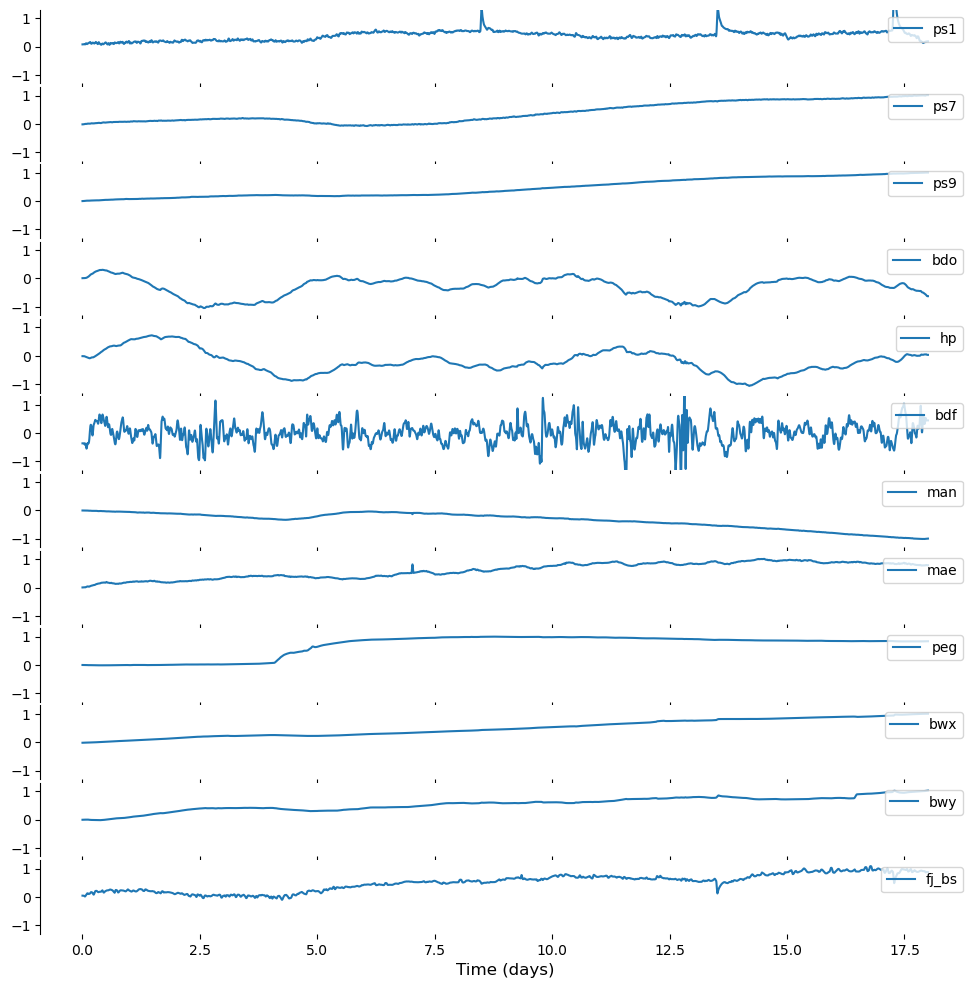

In [37]:
fig = __makeplot0(df);

fig.savefig(config['path_to_figs']+f"SF_R{config['ring']}_{config['modeldata']}_data.png",
            format="png", dpi=150, bbox_inches='tight')


In [42]:
# targetx = "fj_fs"
targetx = "fj_bs"
# targetx = "fj_bs_dj"

featuresx = ['time', targetx, 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

dfx = df[featuresx].copy()

N = dfx.shape[0]

df1_part1 = dfx.copy().iloc[:int(N*3/4)]
df1_part2 = dfx.copy().iloc[int(N*3/4):]

features_model = ['time', targetx, 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
# features_model = ['time', 'fj_bs', 'ps1', 'ps7', 'ps9']

out = __find_model(df1_part1, features_model, target=targetx, reg="ransac")

t_predict, d_predict = __predict_data(df1_part2, features_model, out['model'], target=targetx)


['bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9825599119342077
IC:  0.0006058935623149946
Coef:  [ 6.22687638e-02  1.59417018e-06  1.41260255e-04  2.01986493e-05
 -4.32278467e-04  1.45154563e-03 -4.22763408e-03  2.62655974e+02
  7.24931338e+02 -2.55875121e-04]
bwx : 0.062268763833559455
bwy : 1.5941701782338691e-06
bdo : 0.0001412602549492906
hp : 2.019864934988114e-05
ps1 : -0.0004322784670314823
ps7 : 0.0014515456304941808
ps9 : -0.0042276340806735565
mae : 262.6559738345068
man : 724.9313377361691
peg : -0.0002558751206510694


In [44]:
def __makeplot1(df0, df1, df2,
                tp1, dp1, model1, target1,
               ):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from numpy import array

    def __corr(df_in, m="kendall", targetx="not_the_one"):

        _df = df_in.copy()

        if "time" in list(_df.columns):
            _df.drop(columns="time", inplace=True)
        # if targetx in list(_df.columns):
        #     _df.drop(columns=targetx, inplace=True)

        _df = _df.iloc[:, :]

        corr = _df.corr(method=m.lower())

        # mask upper triangle
        corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

        return corr

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        vr = round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)
        return vr


    # correlatin matrix
    c_method = "Kendall" # kendall pearson spearman
    corr1 = __corr(df0, m=c_method, targetx=target1)

    # variance reduction
    dat = array(df2[target1])
    res = dat - dp1
    VR = __variance_reduction(dat, res)

    # root mean square error
    rmse = __rmse(dat, dp1)

    # _________________________________________
    #

    yscale, yunit = 1e3, "mHz"

    tscale = 1/86400

    Nrow, Ncol = 1, 15

    cmap = plt.get_cmap("coolwarm", 9)

    fig = plt.figure(figsize=(15, 5))

    font = 12

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=1.2)

    ax0 = fig.add_subplot(gs[0, :10])
    ax1 = fig.add_subplot(gs[0, 10:])

    axes = [ax0, ax1]

    ax0.plot(df1.time*tscale, df1[target1]*yscale, color="k", label="observed (training)", alpha=0.7)
    ax0.plot(model1['tp']*tscale, array(model1['dp'])*yscale, color="tab:red", label="modelled (training)", alpha=0.7)

    ax0.fill_betweenx([-1000, 1000], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax0.plot(df2.time*tscale, df2[target1]*yscale, color="k", label="observed")
    ax0.plot(tp1*tscale, dp1*yscale, color="purple", label="predicted")
    ax0.set_xlabel("Time (days)", fontsize=font)

    im1 = ax1.pcolor(corr1, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")

    labels = list(corr1.columns)
    # ax1.yaxis.set_label_position("right")
    # ax1.yaxis.tick_right()
    ax1.set_xticks(np.arange(len(labels))+0.5)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(len(labels))+0.5)
    # ax1.set_yticklabels(reversed(labels))
    ax1.set_yticklabels(labels)


    ax1.text(0.5, 0.97, f"{c_method} rank correlation", ha="center", va="top", transform=ax1.transAxes, fontsize=font-1)

    for ax in [ax0]:

        ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax.legend(loc=9, fontsize=font-2, ncol=2)
        ax.set_ylabel(f"$\Delta$f ({yunit})", fontsize=font)

    ax0.text(0.97, 0.27, f"R$^2$ = {model1['r2']:.3f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.text(0.97, 0.20, f"$\sigma_R$ = {VR:.2f}%", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.text(0.97, 0.12, f"RMSE = {rmse:.5f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.set_xlim(0, df2.time.max()*tscale)


    ax0.set_ylim(np.nanpercentile(df0[target1], 3)*yscale*2, np.nanpercentile(df0[target1], 97)*yscale*2)
    ax0.set_ylim(-1, 6)

    mod = ""
    for i, ll in enumerate(features_model):
        mod += f"c$_{i}$ ${ll}$ + "

    tit1 = f"{target1} = {mod}"
    ax0.set_title(tit1[:-2], pad=10)

    axes = [ax0, ax1]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.01, .98, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig

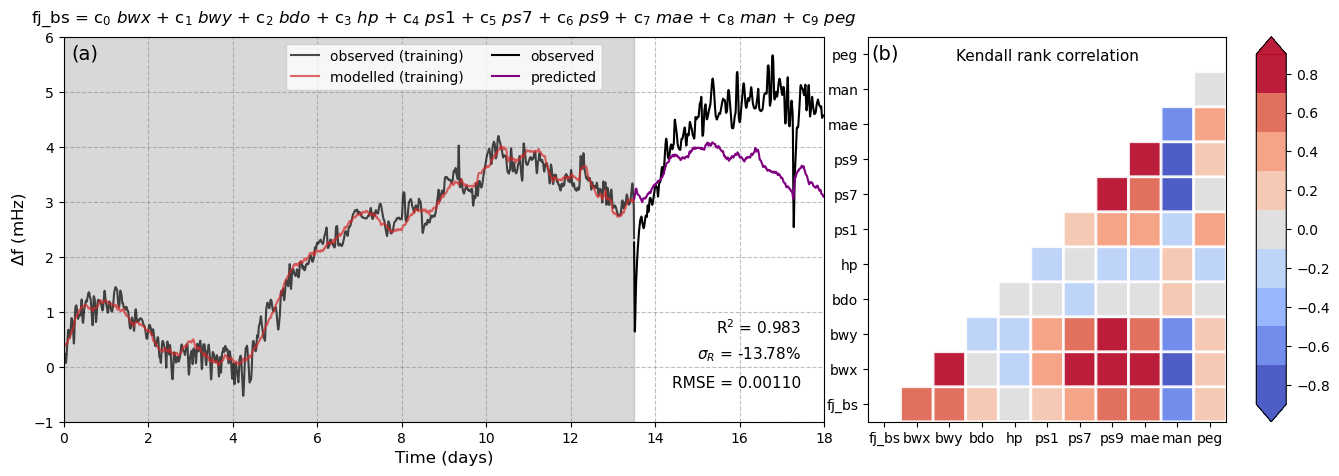

In [45]:
fig = __makeplot1(dfx, df1_part1, df1_part2,
                  t_predict, d_predict, out, targetx,
                  );

fig.savefig(config['path_to_figs']+f"SF_R{config['ring']}_{config['modeldata']}_sagnac_frequency_model.png",
            format="png", dpi=150, bbox_inches='tight')

del fig

In [46]:
out = __find_model(dfx, features_model, target=targetx, reg="ransac")

t_predict, d_predict = __predict_data(dfx, features_model, out['model'], target=targetx)


['bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9789271363451026
IC:  0.0006827239883631579
Coef:  [ 7.90422327e-02  1.95402146e-05  2.19973776e-04  2.21337726e-05
 -8.24049073e-03  3.11527678e-04 -4.79014453e-03 -4.17210039e+02
  5.44785494e+02 -1.15329133e-03]
bwx : 0.07904223268499708
bwy : 1.9540214592822305e-05
bdo : 0.00021997377646528767
hp : 2.2133772620695252e-05
ps1 : -0.008240490729200679
ps7 : 0.0003115276781469562
ps9 : -0.004790144529210664
mae : -417.21003888943153
man : 544.7854938698667
peg : -0.0011532913254549196


In [52]:
# load data
# df0 = read_pickle(config['path_to_data']+config['file'])

# sampling rate
sps = 1/60

# drift model
pre = np.array([_d[0] for _d in d_predict])

# correct for drift model
df['fj_bs_correct'] = dfx.fj_bs.values - pre


2.6
2.4
0.05


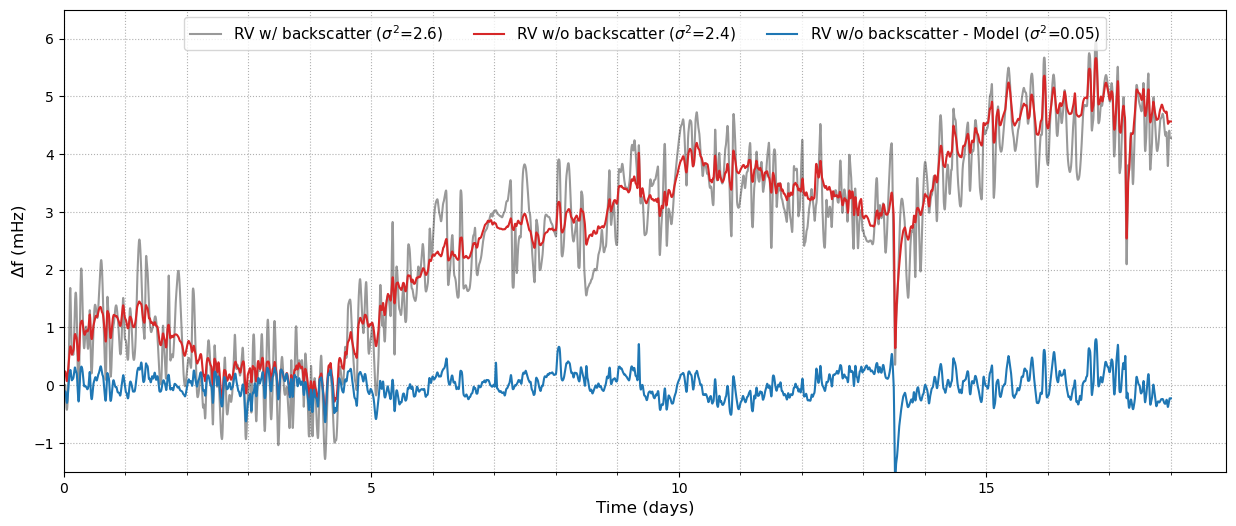

In [50]:
def __makeplot3(_df):

    time = _df.time

    Nrow, Ncol = 1, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fscale, funit = 1e3, "mHz"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 6))

    dat1 = __reduce(_df.fj_fs, 10)*fscale
    dat2 = _df.fj_bs*fscale
    dat3 = _df.fj_bs_correct*fscale

    var1 = round(np.var(dat1), 2)
    var2 = round(np.var(dat2), 2)
    var3 = round(np.var(dat3), 2)

    ax.plot(time*tscale, dat1, color="black", label=f"RV w/ backscatter ($\sigma^2$={var1})", alpha=0.4)
    ax.plot(time*tscale, dat2, color="tab:red", label=f"RV w/o backscatter ($\sigma^2$={var2})")
    ax.plot(time*tscale, dat3, color="tab:blue", label=f"RV w/o backscatter - Model ($\sigma^2$={var3})")

    ax.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax.set_xlabel(f"Time ({tunit})", fontsize=font)

    ax.set_ylim(-1.5, 6.5)

    ax.grid(ls=":", zorder=0, which="both")
    ax.legend(loc=9, ncol=3, fontsize=font-1)

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.set_xlim(left=0)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.show();
    return fig

fig = __makeplot3(df);

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_{config['modeldata']}_model_reduction.png",
            format="png", dpi=150, bbox_inches='tight')


In [53]:
def get_allan(data, sps):

    import allantools

    # define tau range e.g. 5 (= 10⁵) and number of samples N
    upper = 6
    lower = -4
    N = 150

    # list of tau values in seconds
    taux = np.logspace(lower, upper, N)

    #compute allan
    allan = allantools.oadev(data,
                             data_type='freq',
                             rate=sps,
                             taus='all', # all, octave, decade
                             )

    return np.array(allan[0]), np.array(allan[1]), np.array(allan[2])

In [24]:
# tau1, adev1, err1 = get_allan(df0.fj_fs/447.728, sps)
# tau2, adev2, err2 = get_allan(df0.fj_bs/447.728, sps)
# tau3, adev3, err3 = get_allan(fcorrect/447.728, sps)

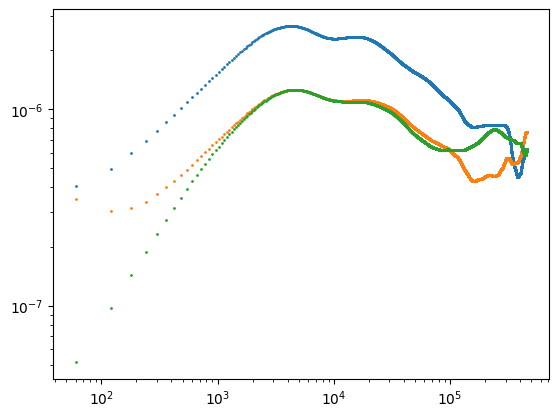

In [25]:
# plt.scatter(tau1, adev1, s=1)
# plt.scatter(tau2, adev2, s=1)
# plt.scatter(tau3, adev3, s=1)

# plt.xscale("log")
# plt.yscale("log")

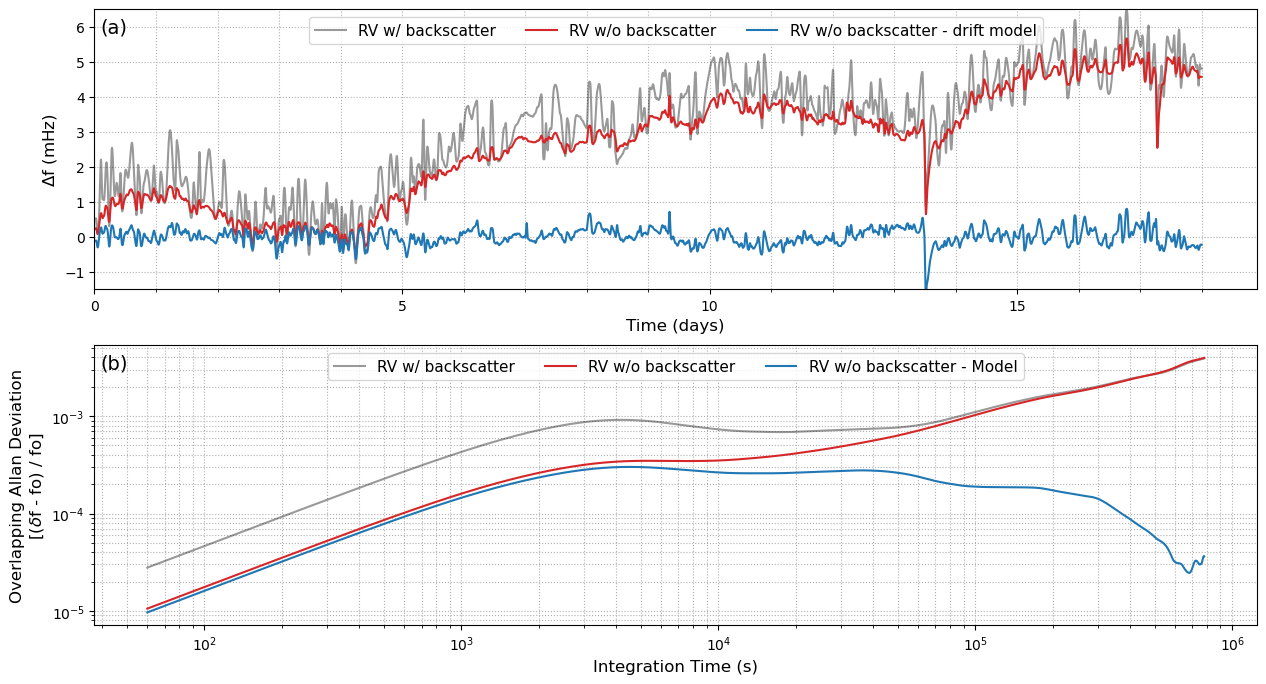

In [57]:
def __makeplot(_df, fs0=447.728, sps=1/60):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    fscale, funit = 1e3, "mHz"

    dat1 = _df.fj_fs*fscale
    dat2 = _df.fj_bs*fscale
    dat3 = _df.fj_bs_correct*fscale

    # to Hz
    _dat1 = _df.fj_fs*fscale *1e3
    _dat2 = _df.fj_bs*fscale *1e3
    _dat3 = _df.fj_bs_correct*fscale *1e3

    tau1, adev1, err1 = get_allan(dat1/fs0, sps)
    tau2, adev2, err2 = get_allan(dat2/fs0, sps)
    tau3, adev3, err3 = get_allan(dat3/fs0, sps)

    time = _df.time

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, (ax1, ax2) = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    # var1 = round(np.var(dat1), 2)
    # var2 = round(np.var(dat2), 2)
    # var3 = round(np.var(dat3), 2)

    ax1.plot(time*tscale, dat1, color="black", label=f"RV w/ backscatter", alpha=0.4)
    ax1.plot(time*tscale, dat2, color="tab:red", label=f"RV w/o backscatter")
    ax1.plot(time*tscale, dat3, color="tab:blue", label=f"RV w/o backscatter - drift model")

    ax1.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax1.set_xlabel(f"Time ({tunit})", fontsize=font)

    ax1.set_ylim(-1.5, 6.5)

    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))

    ax1.set_xlim(left=0)

    ax2.plot(tau1, adev1, color="black", label=f"RV w/ backscatter", alpha=0.4)
    ax2.plot(tau2, adev2, color="tab:red", label=f"RV w/o backscatter")
    ax2.plot(tau3, adev3, color="tab:blue", label=f"RV w/o backscatter - Model")

    ax2.set_xscale("log")
    ax2.set_yscale("log")

    ax2.set_ylabel(f"Overlapping Allan Deviation\n[($\delta$f - fo) / fo]", fontsize=font)
    ax2.set_xlabel(f"Integration Time (s)", fontsize=font)

    for ax in [ax1, ax2]:
        ax.grid(ls=":", zorder=0, which="both")
        ax.legend(loc=9, ncol=3, fontsize=font-1)

    axes = [ax1, ax2]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot(df, fs0=447.728, sps=1/60);

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_{config['modeldata']}_model_reduction_allan.png",
            format="png", dpi=150, bbox_inches='tight')


### 